# Job characterization

In this notebook, we explore the characteristics of the job level, including the resource demands, duration, queuing time and final status.

In [1]:
"""
Note that only the `Venus` trace is public available now. 
Other traces are being censored. We will release them as soon as possible.
"""
# cluster_list = ["Venus", "Earth", "Saturn", "Uranus"]
cluster_list = ["Venus"]

In [2]:
from datetime import timedelta

import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rc
from pylab import *

matplotlib.font_manager._rebuild()

sns.set_style("ticks")
font = {
    "font.family": "Roboto",
    "font.size": 12,
}
sns.set_style(font)
paper_rc = {
    "lines.linewidth": 3,
    "lines.markersize": 10,
}
sns.set_context("paper", font_scale=1.6, rc=paper_rc)
current_palette = sns.color_palette()


def load_data(cluster, opt):
    """Data Loading & Processing"""
    if opt == "seq":
        df = pd.read_csv(
            f"../../data/{cluster}/cluster_sequence.csv",
            parse_dates=["time"],
            index_col="time",
        )
    elif opt == "log":
        df = pd.read_csv(
            f"../../data/{cluster}/cluster_log.csv",
            parse_dates=["submit_time", "start_time", "end_time"],
        )
    else:
        raise ValueError("Please check opt")

    return df

## Job Execution Time - GPU & CPU jobs
Distributions of GPU (a) and CPU (b) jobs over execution time.

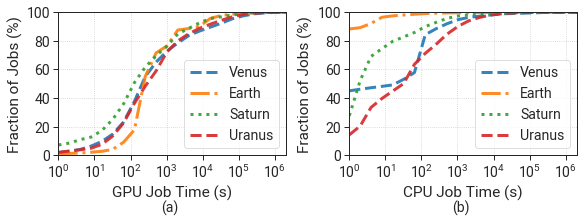

In [3]:
def plot_cdf_job_time(cluster_list, save=True):
    fig, (ax1, ax2) = plt.subplots(
        ncols=2, nrows=1, constrained_layout=True, figsize=(8, 3)
    )

    linestyles = ["--", "-.", ":", "--"]

    for k in range(0, len(cluster_list)):
        job_ratio, cjob_ratio = [], []
        time = [2 ** i for i in range(0, 22)]
        log = load_data(cluster_list[k], "log")
        clog = log[log["gpu_num"] == 0]  # CPU Log
        log = log[log["gpu_num"] > 0]  # GPU Log

        for t in time:
            job_ratio.append(len(log[log["duration"] <= t]) / len(log) * 100)
            cjob_ratio.append(len(clog[clog["duration"] <= t]) / len(clog) * 100)

        ax1.plot(
            time, job_ratio, linestyles[k], alpha=0.9, label=cluster_list[k],
        )

        ax2.plot(
            time, cjob_ratio, linestyles[k], alpha=0.9, label=cluster_list[k],
        )

    ax1.set_xlabel(f"GPU Job Time (s)")
    ax1.set_ylabel(f"Fraction of Jobs (%)")
    ax1.set_xscale("log")
    ax1.set_xticks([1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6])
    ax1.set_xlim(1, time[-1])
    ax1.set_ylim(0, 100)
    ax1.legend(loc="lower right")
    ax1.grid(linestyle=":")
    ax1.text(0.45, -0.4, "(a)", transform=ax1.transAxes, size=14)

    ax2.set_xlabel(f"CPU Job Time (s)")
    ax2.set_ylabel(f"Fraction of Jobs (%)")
    ax2.set_xscale("log")
    ax2.set_xticks([1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6])
    ax2.set_xlim(1, time[-1])
    ax2.set_ylim(0, 100)
    ax2.legend(loc="lower right")
    ax2.grid(linestyle=":")
    ax2.text(0.45, -0.4, "(b)", transform=ax2.transAxes, size=14)

    if save:
        fig.savefig(
            f"./job_cdf_jobtime.pdf", bbox_inches="tight", dpi=600,
        )


plot_cdf_job_time(cluster_list, save=True)

## Job Execution Time - GPU Number
The CDFs of job sizes (in GPU number) with thenumber of jobs (a) and GPU time (b).

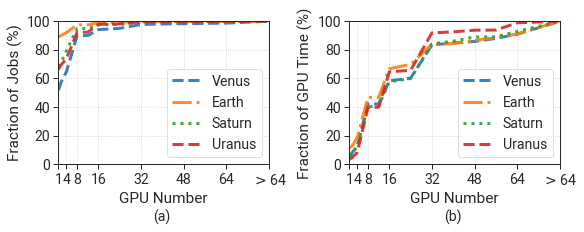

In [4]:
def plot_cdf_job_gpu_num(cluster_list, save=True):
    fig, (ax1, ax2) = plt.subplots(
        ncols=2, nrows=1, constrained_layout=True, figsize=(8, 3)
    )

    linestyles = ["--", "-.", ":", "--"]

    for k in range(0, len(cluster_list)):
        job_ratio, gtime_ratio = [], []
        gpu = [1, 2, 4, 8, 12, 16, 24, 32, 40, 48, 56, 64, 80]
        log = load_data(cluster_list[k], "log")
        log = log[log["gpu_num"] > 0]  # GPU Log

        log["gtime"] = log["duration"] * log["gpu_num"]
        gtime_sum = log["gtime"].sum()

        for t in gpu:
            if t > 64:
                job_ratio.append(len(log[log["gpu_num"] <= 2048]) / len(log) * 100)
                gtime_ratio.append(
                    log[log["gpu_num"] <= 2048]["gtime"].sum() / gtime_sum * 100
                )
                break
            job_ratio.append(len(log[log["gpu_num"] <= t]) / len(log) * 100)
            gtime_ratio.append(
                log[log["gpu_num"] <= t]["gtime"].sum() / gtime_sum * 100
            )

        ax1.plot(
            gpu, job_ratio, linestyles[k], alpha=0.9, label=cluster_list[k],
        )

        ax2.plot(
            gpu, gtime_ratio, linestyles[k], alpha=0.9, label=cluster_list[k],
        )

    xticks = [1, 4, 8, 16, 32, 48, 64, 80]
    ax1.set_xlabel(f"GPU Number")
    ax1.set_ylabel(f"Fraction of Jobs (%)")
    ax1.set_xticks(xticks)
    ax1.set_xticklabels([1, 4, 8, 16, 32, 48, 64, "$>$64"])
    ax1.set_xlim(1, gpu[-1])
    ax1.set_ylim(0, 100)
    ax1.legend(loc="lower right")
    ax1.text(0.45, -0.4, "(a)", transform=ax1.transAxes, size=14)
    ax1.grid(linestyle=":")

    ax2.set_xlabel(f"GPU Number")
    ax2.set_ylabel(f"Fraction of GPU Time (%)")
    ax2.set_xticks(xticks)
    ax2.set_xticklabels([1, 4, 8, 16, 32, 48, 64, "$>$64"])
    ax2.set_xlim(1, gpu[-1])
    ax2.set_ylim(0, 100)
    ax2.legend(loc="lower right")
    ax2.text(0.45, -0.4, "(b)", transform=ax2.transAxes, size=14)
    ax2.grid(linestyle=":")

    if save:
        fig.savefig(
            f"./job_cdf_gpunum.pdf", bbox_inches="tight", dpi=600,
        )


plot_cdf_job_gpu_num(cluster_list, save=True)

## Job Final Statuses
Distribution of jobs by their final statuses. 

(a) Comparisons of CPUandGPUjobs for their final statuses. 

(b) Fraction of final job statuses w.r.t. different GPU demands.

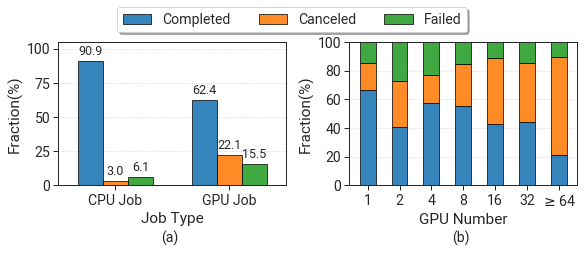

In [5]:
def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            "%.1f" % height,
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
            size=12.5,
        )


def bar_completerate_gpu_num(save=True):
    fig, (ax1, ax2) = plt.subplots(
        ncols=2, nrows=1, constrained_layout=True, figsize=(8, 3)
    )
    df = pd.read_csv(f"../1_compare with Philly trace/helios_cluster_summary.csv")

    x = np.arange(1, 3)
    width = 0.22
    p1 = ax1.bar(
        x - width,
        df.iloc[-1][["complete_rate_cpu", "complete_rate_gpu"]] * 100,
        width,
        label="Completed",
        alpha=0.9,
        linewidth=0.8,
        edgecolor="k",
    )
    p2 = ax1.bar(
        x,
        df.iloc[-1][["cancel_rate_cpu", "cancel_rate_gpu"]] * 100,
        width,
        label="Canceled",
        alpha=0.9,
        linewidth=0.8,
        edgecolor="k",
    )
    p3 = ax1.bar(
        x + width,
        df.iloc[-1][["fail_rate_cpu", "fail_rate_gpu"]] * 100,
        width,
        label="Failed",
        alpha=0.9,
        linewidth=0.8,
        edgecolor="k",
    )
    autolabel(p1, ax1)
    autolabel(p2, ax1)
    autolabel(p3, ax1)

    ax1.set_xlabel(f"Job Type")
    ax1.set_ylabel(f"Fraction(%)")
    ax1.set_xticks(x)
    ax1.set_xticklabels(["CPU Job", "GPU Job"])
    ax1.set_xlim(0.5, 2.5)
    ax1.set_ylim(0, 105)
    ax1.grid(axis="y", linestyle=":")
    ax1.text(0.45, -0.4, "(a)", transform=ax1.transAxes, size=14)

    x = np.arange(1, 8)
    gpu = [1, 2, 4, 8, 16, 32, 64]
    width = 0.5

    comp_ls, canc_ls, fail_ls = [], [], []
    log = pd.read_csv(f"../../data/all_cluster_log.csv")
    log = log[log["gpu_num"] > 0]  # GPU Log

    complete = log[log["state"] == "COMPLETED"]
    cancel = log[log["state"] == "CANCELLED"]
    fail = log[(log["state"] != "CANCELLED") & (log["state"] != "COMPLETED")]
    for t in gpu:
        if t < 64:
            comp_ls.append(
                len(complete[complete["gpu_num"] == t])
                / len(log[log["gpu_num"] == t])
                * 100
            )
            canc_ls.append(
                len(cancel[cancel["gpu_num"] == t])
                / len(log[log["gpu_num"] == t])
                * 100
            )
            fail_ls.append(
                len(fail[fail["gpu_num"] == t]) / len(log[log["gpu_num"] == t]) * 100
            )
        else:
            comp_ls.append(
                len(complete[complete["gpu_num"] >= t])
                / len(log[log["gpu_num"] >= t])
                * 100
            )
            canc_ls.append(
                len(cancel[cancel["gpu_num"] >= t])
                / len(log[log["gpu_num"] >= t])
                * 100
            )
            fail_ls.append(
                len(fail[fail["gpu_num"] >= t]) / len(log[log["gpu_num"] >= t]) * 100
            )

    base = [canc_ls[i] + comp_ls[i] for i in range(len(comp_ls))]

    ax2.bar(
        x, comp_ls, width, alpha=0.9, linewidth=0.8, edgecolor="k", label="Completed"
    )
    ax2.bar(
        x,
        canc_ls,
        width,
        bottom=comp_ls,
        alpha=0.9,
        linewidth=0.8,
        edgecolor="k",
        label="Canceled",
    )
    ax2.bar(
        x,
        fail_ls,
        width,
        bottom=base,
        alpha=0.9,
        linewidth=0.8,
        edgecolor="k",
        label="Failed",
    )
    ax2.set_xlabel(f"GPU Number")
    ax2.set_ylabel(f"Fraction(%)")
    ax2.set_ylim(0, 100)
    ax2.set_xticks(x)
    ax2.set_xticklabels([1, 2, 4, 8, 16, 32, "$\geq$64"])
    ax2.grid(axis="y", linestyle=":")
    ax2.text(0.45, -0.4, "(b)", transform=ax2.transAxes, size=14)

    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc="upper center",
        ncol=3,
        bbox_to_anchor=(0.5, 1.155),
        fancybox=True,
        shadow=True,
    )

    if save:
        fig.savefig(
            f"./job_bar_gpu_num_complete_rate.pdf", bbox_inches="tight", dpi=600,
        )


bar_completerate_gpu_num(save=True)